## Library

In [3]:
#!pip install dill


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import List, Tuple, Dict, Union, Optional
import dill
from sklearn.preprocessing import StandardScaler

## Decision Tree

In [3]:
class DecisionTreeNode:
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value
        self.gini = None
        self.gain = None

class DecisionTree:
    def __init__(self, max_depth: int, min_samples_split: int,
                 class_weight: Optional[Dict[int, float]] = None,
                 random_state: Optional[int] = None):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.class_weight = class_weight
        self.random_state = random_state
        self.root = None
        self.n_classes = None
        self.feature_importances_ = None

        if random_state is not None:
            np.random.seed(random_state)

    def _calculate_weighted_gini(self, y: np.ndarray) -> float:
        if len(y) == 0:
            return 0.0

        _, counts = np.unique(y, return_counts=True)
        proportions = counts / len(y)

        if self.class_weight is not None:
            weights = np.array([self.class_weight.get(c, 1.0) for c in range(self.n_classes)])
            proportions = proportions * weights
            proportions = proportions / proportions.sum()

        return 1.0 - np.sum(proportions ** 2)

    def _split_data(self, X: np.ndarray, y: np.ndarray, feature: int,
                    threshold: float) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
        left_mask = X[:, feature] <= threshold
        right_mask = ~left_mask

        return (X[left_mask], X[right_mask],
                y[left_mask], y[right_mask])

    def _calculate_information_gain(self, y_parent: np.ndarray, y_left: np.ndarray,
                                  y_right: np.ndarray) -> float:
        n_left, n_right = len(y_left), len(y_right)
        n_parent = len(y_parent)

        if n_parent == 0:
            return 0.0

        gini_parent = self._calculate_weighted_gini(y_parent)
        gini_left = self._calculate_weighted_gini(y_left)
        gini_right = self._calculate_weighted_gini(y_right)

        w_left = n_left / n_parent
        w_right = n_right / n_parent

        return gini_parent - (w_left * gini_left + w_right * gini_right)

    def _find_best_split(self, X: np.ndarray, y: np.ndarray, feature_subset: Optional[List[int]] = None) -> Tuple[int, float, float]:
        best_gain = -float('inf')
        best_feature = None
        best_threshold = None
        eps = 1e-10

        features = (feature_subset if feature_subset is not None else range(X.shape[1]))
        n_samples = len(y)

        _, class_counts = np.unique(y, return_counts=True)
        proportions = class_counts / (n_samples + eps)
        gini_parent = 1.0 - np.sum(proportions ** 2)

        for feature in features:
            sorted_indices = np.argsort(X[:, feature])
            sorted_x = X[sorted_indices, feature]
            sorted_y = y[sorted_indices]

            unique_values = np.unique(sorted_x)

            if len(unique_values) < 2:
                continue

            thresholds = (unique_values[1:] + unique_values[:-1]) / 2

            for threshold in thresholds:
                left_mask = sorted_x <= threshold
                right_mask = ~left_mask

                y_left = sorted_y[left_mask]
                y_right = sorted_y[right_mask]

                if len(y_left) < self.min_samples_split or len(y_right) < self.min_samples_split:
                    continue

                _, left_counts = np.unique(y_left, return_counts=True)
                _, right_counts = np.unique(y_right, return_counts=True)

                n_left = len(y_left)
                n_right = len(y_right)

                left_proportions = left_counts / (n_left + eps)
                right_proportions = right_counts / (n_right + eps)

                gini_left = 1.0 - np.sum(left_proportions ** 2)
                gini_right = 1.0 - np.sum(right_proportions ** 2)

                gain = gini_parent - (n_left/n_samples * gini_left + n_right/n_samples * gini_right)

                if gain > best_gain:
                    best_gain = gain
                    best_feature = feature
                    best_threshold = threshold

        return best_feature, best_threshold, best_gain

    def _build_tree(self, X: np.ndarray, y: np.ndarray, depth: int = 0,
                    feature_subset: Optional[List[int]] = None) -> DecisionTreeNode:
        n_samples = len(y)

        if (depth >= self.max_depth or
            n_samples < self.min_samples_split or
            len(np.unique(y)) == 1):

            if self.class_weight is not None:
                counts = np.bincount(y, weights=[self.class_weight.get(yi, 1.0) for yi in y])
            else:
                counts = np.bincount(y)

            node = DecisionTreeNode(value=np.argmax(counts))
            node.gini = self._calculate_weighted_gini(y)
            return node

        best_feature, best_threshold, best_gain = self._find_best_split(
            X, y, feature_subset
        )

        if best_feature is None:
            node = DecisionTreeNode(value=np.argmax(np.bincount(y)))  
            node.gini = self._calculate_weighted_gini(y)
            return node

        X_left, X_right, y_left, y_right = self._split_data(
            X, y, best_feature, best_threshold
        )

        node = DecisionTreeNode(
            feature=best_feature,
            threshold=best_threshold
        )

        node.gini = self._calculate_weighted_gini(y)
        node.gain = best_gain

        node.left = self._build_tree(X_left, y_left, depth + 1, feature_subset)
        node.right = self._build_tree(X_right, y_right, depth + 1, feature_subset)

        return node

    def fit(self, X: np.ndarray, y: np.ndarray,
            feature_subset: Optional[List[int]] = None) -> 'DecisionTree':
        y = y.astype(np.int32)
        self.n_classes = len(np.unique(y))

        if self.class_weight is None:
            class_counts = np.bincount(y)
            total = len(y)
            self.class_weight = {
                c: total / (self.n_classes * count)
                for c, count in enumerate(class_counts)
            }

        self.root = self._build_tree(X, y, feature_subset=feature_subset)
        self._calculate_feature_importance(X)
        return self

    def _traverse_tree(self, x: np.ndarray, node: DecisionTreeNode) -> int:
        if node.value is not None:
            return node.value

        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)

    def predict(self, X: np.ndarray) -> np.ndarray:
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def _calculate_feature_importance(self, X: np.ndarray):
        self.feature_importances_ = np.zeros(X.shape[1])
        self._update_feature_importance(self.root, 1.0)

        if np.sum(self.feature_importances_) > 0:
            self.feature_importances_ /= np.sum(self.feature_importances_)

    def _update_feature_importance(self, node: DecisionTreeNode, weight: float):
        if node.feature is not None:
            self.feature_importances_[node.feature] += weight * (node.gain or 0)
            if node.left:
                self._update_feature_importance(node.left, weight * 0.5)
            if node.right:
                self._update_feature_importance(node.right, weight * 0.5)

## Random Forest

In [4]:
class RandomForest:
    def __init__(self, n_estimators: int, max_depth: int,
                 min_samples_split: int, max_features: Union[str, float] = 'sqrt',
                 random_state: Optional[int] = None):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.max_features = max_features
        self.random_state = random_state
        self.trees = []
        self.feature_importances_ = None
        self.n_features = None

        if random_state is not None:
            np.random.seed(random_state)

    def _bootstrap_sample(self, X: np.ndarray, y: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        n_samples = X.shape[0]
        indices = np.random.choice(n_samples, size=n_samples, replace=True)
        return X[indices], y[indices]

    def _get_feature_subset_size(self, n_features: int) -> int:
        if isinstance(self.max_features, str):
            if self.max_features == 'sqrt':
                return int(np.sqrt(n_features))
            elif self.max_features == 'log2':
                return int(np.log2(n_features))
        elif isinstance(self.max_features, float):
            return max(1, int(self.max_features * n_features))
        return n_features

    def fit(self, X: np.ndarray, y: np.ndarray):
        self.n_features = X.shape[1]
        self.trees = []
        n_features_subset = self._get_feature_subset_size(self.n_features)

        print(f"\nTraining Random Forest with {self.n_estimators} trees...")
        print(f"Features per tree: {n_features_subset}/{self.n_features}")

        for i in range(self.n_estimators):
            if (i + 1) % 10 == 0:
                print(f"Training tree {i + 1}/{self.n_estimators}")

            X_sample, y_sample = self._bootstrap_sample(X, y)

            feature_subset = np.random.choice(
                self.n_features,
                size=n_features_subset,
                replace=False
            )

            tree = DecisionTree(
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split,
                random_state=self.random_state + i if self.random_state else None
            )

            X_subset = X_sample[:, feature_subset]
            tree.fit(X_subset, y_sample)

            self.trees.append((tree, feature_subset))

        self._calculate_feature_importance()
        return self

    def _calculate_feature_importance(self):
        importances = np.zeros(self.n_features)
        counts = np.zeros(self.n_features)

        for tree, feature_subset in self.trees:
            for idx, feature in enumerate(feature_subset):
                if tree.feature_importances_ is not None:
                    importances[feature] += tree.feature_importances_[idx]
                    counts[feature] += 1

        mask = counts > 0
        importances[mask] /= counts[mask]

        if np.sum(importances) > 0:
            importances /= np.sum(importances)

        self.feature_importances_ = importances

    def predict(self, X: np.ndarray) -> np.ndarray:
        if X.shape[1] != self.n_features:
            raise ValueError(
                f"Number of features in prediction data ({X.shape[1]}) "
                f"does not match training data ({self.n_features})"
            )

        predictions = np.zeros((len(X), self.n_estimators))

        for i, (tree, feature_subset) in enumerate(self.trees):
            X_subset = X[:, feature_subset]
            predictions[:, i] = tree.predict(X_subset)

        return np.apply_along_axis(lambda x: np.argmax(np.bincount(x)), axis=1, arr=predictions.astype(int))

    def get_feature_importance_plot(self, feature_names=None):
        if self.feature_importances_ is None:
            raise ValueError("No feature importances available. Model must be trained first.")

        importances = self.feature_importances_
        indices = np.argsort(importances)[::-1]

        plt.figure(figsize=(10, 6))
        plt.title('Feature Importances')

        if feature_names is None:
            feature_names = [f'Feature {i}' for i in range(len(importances))]

        plt.bar(range(len(importances)),
                importances[indices],
                align='center')
        plt.xticks(range(len(importances)),
                   [feature_names[i] for i in indices],
                   rotation=45)
        plt.xlabel('Features')
        plt.ylabel('Importance')
        plt.tight_layout()
        plt.show()

## Features Engineering

In [6]:
def engineer_features(df: pd.DataFrame, scaler: Optional[StandardScaler] = None) -> pd.DataFrame:
        df_engineered = df.copy()
        eps = 1e-10  
        
        if scaler is None:
             scaler = StandardScaler()
             scaler.fit(df[['amount']])
        df_engineered['amount_normalized'] = scaler.transform(df[['amount']])
        df_engineered['amount_log'] = np.log1p(df['amount'])
        df_engineered['is_large_transaction'] = (df['amount'] > df['amount'].quantile(0.95)).astype(int)
        
        df_engineered['balance_diff_orig'] = df['oldbalanceOrg'] - df['newbalanceOrig']
        df_engineered['balance_diff_dest'] = df['newbalanceDest'] - df['oldbalanceDest']
        
        df_engineered['balance_ratio_orig'] = (df['newbalanceOrig'] + eps) / (df['oldbalanceOrg'] + eps)
        df_engineered['balance_ratio_dest'] = (df['newbalanceDest'] + eps) / (df['oldbalanceDest'] + eps)
        
        df_engineered['orig_zero_after_tx'] = (df['newbalanceOrig'] == 0).astype(int)
        df_engineered['orig_zero_before_tx'] = (df['oldbalanceOrg'] == 0).astype(int)
        df_engineered['dest_zero_after_tx'] = (df['newbalanceDest'] == 0).astype(int)
        df_engineered['dest_zero_before_tx'] = (df['oldbalanceDest'] == 0).astype(int)
        
        df_engineered['balance_error_orig'] = abs(df['oldbalanceOrg'] - df['amount'] - df['newbalanceOrig'])
        df_engineered['balance_error_dest'] = abs(df['newbalanceDest'] - df['oldbalanceDest'] - df['amount'])
        df_engineered['has_balance_error'] = ((df_engineered['balance_error_orig'] > eps) | 
                                            (df_engineered['balance_error_dest'] > eps)).astype(int)
        
        df_engineered['amount_to_oldbalance_ratio'] = df['amount'] / (df['oldbalanceOrg'] + eps)
        df_engineered['amount_to_newbalance_ratio'] = df['amount'] / (df['newbalanceOrig'] + eps)
        
        tx_types = ['CASH_OUT', 'TRANSFER', 'CASH_IN', 'DEBIT', 'PAYMENT']
        for tx_type in tx_types:
            df_engineered[f'type_{tx_type}'] = (df['type'] == tx_type).astype(int)
        
        df_engineered['hour'] = df['step'] % 24
        df_engineered['day'] = df['step'] // 24
        
        df_engineered['is_merchant'] = (df['nameDest'].str.startswith('M')).astype(int)
        
        risk_factors = [
            df_engineered['is_large_transaction'],
            df_engineered['orig_zero_after_tx'],
            df_engineered['has_balance_error'],
            ((df_engineered['type_CASH_OUT'] == 1) & (df_engineered['amount_to_oldbalance_ratio'] > 0.9)).astype(int),
            (df_engineered['amount_to_oldbalance_ratio'] > 0.9).astype(int)
        ]
        df_engineered['risk_score'] = sum(risk_factors)
        
        df_engineered['suspicious_pattern'] = (
            (df_engineered['type_TRANSFER'] & df_engineered['orig_zero_after_tx']) |  
            (df_engineered['type_CASH_OUT'] & (df_engineered['amount_to_oldbalance_ratio'] > 0.9)) | 
            (df_engineered['is_large_transaction'] & df_engineered['has_balance_error']) | 
            (df_engineered['risk_score'] >= 3)  
        ).astype(int)

        df_engineered['fraud_pattern'] = (df['amount'] == df['oldbalanceOrg']).astype(int)
        
        columns_to_drop = ['nameDest', 'nameOrig', 'isFlaggedFraud', 'type', 'step']
        df_engineered = df_engineered.drop(columns=[col for col in columns_to_drop if col in df_engineered.columns])
        
        
        feature_names = df_engineered.columns.tolist()
            
        return df_engineered, feature_names, scaler

## Handling Imbalanced Dataset

In [8]:
def handle_imbalanced_data(X: np.ndarray, y: np.ndarray, strategy: str) -> Tuple[np.ndarray, np.ndarray]:
    print(f"\nOriginal dataset composition:")
    print(f"Fraud transactions: {np.sum(y == 1)}")
    print(f"Non-fraud transactions: {np.sum(y == 0)}")
    ratio = np.sum(y == 0) / (np.sum(y == 1) + 1e-10)
    print(f"Ratio fraud:non-fraud = 1:{ratio:.2f}")

    fraud_indices = np.where(y == 1)[0]
    non_fraud_indices = np.where(y == 0)[0]

    n_fraud = len(fraud_indices)
    n_non_fraud = len(non_fraud_indices)

    if strategy == 'undersample':
        target_non_fraud = min(n_fraud * 10, n_non_fraud)
        selected_non_fraud_indices = np.random.choice(
            non_fraud_indices,
            size=target_non_fraud,
            replace=False
        )
        selected_indices = np.concatenate([fraud_indices, selected_non_fraud_indices])

    elif strategy == 'oversample':
        target_fraud = n_non_fraud // 10
        fraud_indices_oversampled = np.random.choice(
            fraud_indices,
            size=target_fraud,
            replace=True
        )
        selected_indices = np.concatenate([fraud_indices_oversampled, non_fraud_indices])

    elif strategy == 'combine':
        target_ratio = 3
        if n_non_fraud / n_fraud > target_ratio:
            target_non_fraud = n_fraud * target_ratio
            selected_non_fraud_indices = np.random.choice(
                non_fraud_indices,
                size=int(target_non_fraud),
                replace=False
            )
            target_fraud = int(target_non_fraud / target_ratio * 1.2)  
            fraud_indices_oversampled = np.random.choice(
                fraud_indices,
                size=target_fraud,
                replace=True
            )
            selected_indices = np.concatenate([fraud_indices_oversampled, selected_non_fraud_indices])
        else:
            return X, y  

    elif strategy == 'smote':
        try:
            from sklearn.preprocessing import StandardScaler
            from imblearn.over_sampling import SMOTENC
            
            categorical_features = []
            for i in range(X.shape[1]):
                if len(np.unique(X[:, i])) <= 2:  
                    categorical_features.append(i)
            
            scaler = StandardScaler()
            X_scaled = X.copy()
            numerical_features = list(set(range(X.shape[1])) - set(categorical_features))
            X_scaled[:, numerical_features] = scaler.fit_transform(X[:, numerical_features])
            
            smote = SMOTENC(
                categorical_features=categorical_features,
                sampling_strategy="auto",  
                k_neighbors=min(5, len(fraud_indices)-1),
                random_state=42
            )
            X_resampled, y_resampled = smote.fit_resample(X_scaled, y)
            
            X_resampled[:, numerical_features] = scaler.inverse_transform(
                X_resampled[:, numerical_features]
            )
            
            print("\nAfter SMOTE resampling:")
            print(f"Fraud transactions: {np.sum(y_resampled == 1)}")
            print(f"Non-fraud transactions: {np.sum(y_resampled == 0)}")
            return X_resampled, y_resampled
            
        except ImportError:
            print("Warning: SMOTE requires imbalanced-learn package. Falling back to combine strategy.")
            return handle_imbalanced_data(X, y, 'combine')
        except Exception as e:
            print(f"Error applying SMOTE: {str(e)}. Falling back to combine strategy.")
            return handle_imbalanced_data(X, y, 'combine')

    if strategy != 'smote':
        X_resampled = X[selected_indices]
        y_resampled = y[selected_indices]
        print("\nAfter resampling:")
        print(f"Fraud transactions: {np.sum(y_resampled == 1)}")
        print(f"Non-fraud transactions: {np.sum(y_resampled == 0)}")
        new_ratio = np.sum(y_resampled == 0) / (np.sum(y_resampled == 1) + 1e-10)
        print(f"New ratio fraud:non-fraud = 1:{new_ratio:.2f}")
        return X_resampled, y_resampled

    return X, y

## Preprocessing Data

In [9]:
def preprocess_data(df: pd.DataFrame, sampling_strategy: str, use_feature_engineering: bool = True) -> Tuple[np.ndarray, np.ndarray]:
    df = df.copy()
    if use_feature_engineering:
        df_engineered, feature_names, scaler = engineer_features(df)
    else:
        df_engineered = df

    X = df_engineered.drop(['isFraud', 'isFlaggedFraud'], axis=1, errors='ignore').values
    y = df['isFraud'].values
    
    if sampling_strategy != 'none':
        X, y = handle_imbalanced_data(X, y, sampling_strategy)
    
    return X, y, feature_names, scaler 

## Evaluate Model

In [11]:
def evaluate_model(y_true: np.ndarray, y_pred: np.ndarray) -> Dict[str, float]:
    tp = np.sum((y_true == 1) & (y_pred == 1))
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))

    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    balanced_accuracy = (recall + specificity) / 2

    g_mean = np.sqrt(recall * specificity) if (recall * specificity) > 0 else 0

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'specificity': specificity,
        'balanced_accuracy': balanced_accuracy,
        'g_mean': g_mean
    }

## Plot Confusion Matrix

In [12]:
def plot_confusion_matrix(y_true: np.ndarray, y_pred: np.ndarray, title: str = "Confusion Matrix"):
    tp = np.sum((y_true == 1) & (y_pred == 1))
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))

    confusion_matrix = np.array([[tn, fp], [fn, tp]])

    plt.figure(figsize=(8, 6))
    plt.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()

    thresh = confusion_matrix.max() / 2
    for i, j in np.ndindex(confusion_matrix.shape):
        plt.text(j, i, format(confusion_matrix[i, j], 'd'),
                ha="center", va="center",
                color="white" if confusion_matrix[i, j] > thresh else "black")

    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    classes = ['Not Fraud', 'Fraud']
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    plt.tight_layout()

## Plot ROC Curve

In [14]:
def plot_roc_curve(y_true: np.ndarray, y_prob: np.ndarray, title: str = "ROC Curve"):
    from sklearn.metrics import roc_curve, auc

    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2,
             label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

## Plot Features Important

In [75]:
def plot_feature_importance(model, feature_names: List[str], title: str = "Feature Importance"):
    importances = model.feature_importances_

    indices = np.argsort(importances)[::-1]

    plt.title(title)
    plt.bar(range(len(importances)),
            importances[indices],
            color='royalblue')

    plt.xticks(range(len(importances)),
               [feature_names[i] for i in indices],
               rotation=45,
               ha='right')
    plt.xlabel('Features')
    plt.ylabel('Importance')

    plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()

# Controller

In [ ]:
def sampling_dataset(df, sample_size):
    isFraud = df[df['isFraud'] == 1]
    nonFraud = df[df['isFraud'] == 0]

    sampling_df = pd.concat([isFraud, nonFraud.sample(n=sample_size, random_state=2)])

    return sampling_df.sample(frac=1, random_state=202).reset_index(drop=True)


try:
    print("Loading data...")
    df = pd.read_csv(r'C:\Users\user\PycharmProjects\pythonProject\ArtificialIntelegent-Project\FraudDetectionForFinancialTransaction\PS_20174392719_1491204439457_log.csv')
    df = sampling_dataset(df, 25_000)

    print("\nPreprocessing data...")
    X, y, feature_names, scaler = preprocess_data(df, sampling_strategy='none', use_feature_engineering=True)

    print("\nSplitting data...")
    indices = np.random.permutation(len(X))
    train_size = int(0.8 * len(X))

    X_train = X[indices[:train_size]]
    y_train = y[indices[:train_size]]
    X_test = X[indices[train_size:]]
    y_test = y[indices[train_size:]]

    print("\nTraining Decision Tree...")
    dt = DecisionTree(max_depth=35, min_samples_split=5)
    dt.fit(X_train, y_train)
    dt_pred = dt.predict(X_test)

    print("\nTraining Random Forest...")
    rf = RandomForest(
        n_estimators=50,
        max_depth=35,
        min_samples_split=5,
        max_features='sqrt',
        random_state=808
    )
    rf.fit(X_train, y_train)
    rf_pred = rf.predict(X_test)

    print("\nModel Evaluation Results:")
    print("\nDecision Tree:")
    dt_metrics = evaluate_model(y_test, dt_pred)
    for metric, value in dt_metrics.items():
        print(f"{metric}: {value:.4f}")

    print("\nRandom Forest:")
    rf_metrics = evaluate_model(y_test, rf_pred)
    for metric, value in rf_metrics.items():
        print(f"{metric}: {value:.4f}")

    plt.figure()

    plot_confusion_matrix(y_test, dt_pred, "Decision Tree Confusion Matrix")

    plot_confusion_matrix(y_test, rf_pred, "Random Forest Confusion Matrix")

    plt.tight_layout()
    plt.show()

    # plt.figure(figsize=(15, 5))

    # plt.subplot(1, 2, 1)
    # plot_feature_importance(dt, feature_names, "Decision Tree Feature Importance")

    # plt.subplot(1, 2, 2)
    # plot_feature_importance(rf, feature_names, "Random Forest Feature Importance")

    # plt.tight_layout()
    # plt.show()

except Exception as e:
    print(f"An error occurred: {str(e)}")
    import traceback
    traceback.print_exc()


Loading data...

Preprocessing data...

Splitting data...

Training Decision Tree...

Training Random Forest...

Training Random Forest with 50 trees...
Features per tree: 5/32


# Validation

<Figure size 640x480 with 0 Axes>

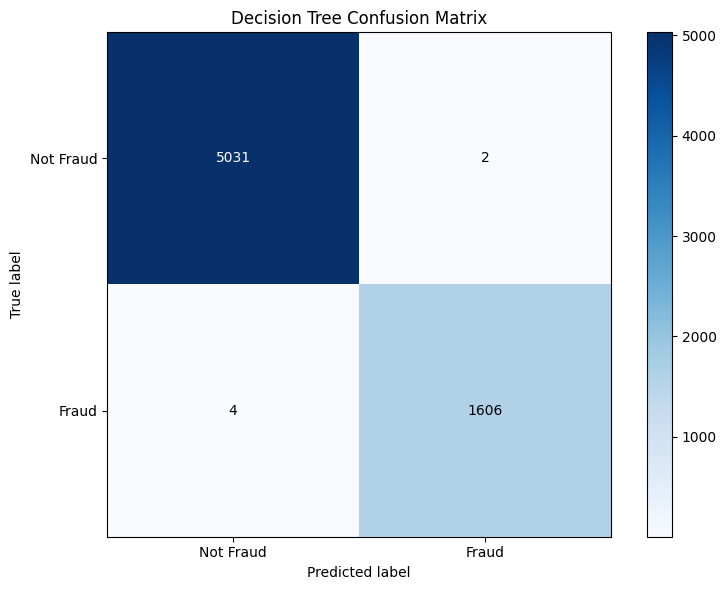

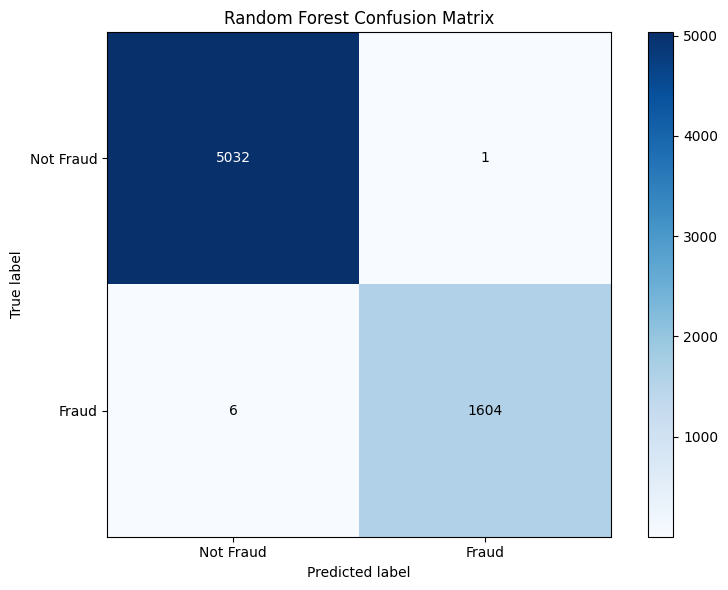

In [48]:
plt.figure()


plot_confusion_matrix(y_test, dt_pred, "Decision Tree Confusion Matrix")

plot_confusion_matrix(y_test, rf_pred, "Random Forest Confusion Matrix")

plt.tight_layout()
plt.show()

In [60]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

rf_sk = RandomForestClassifier(n_estimators=100, max_depth=35, min_samples_split=5, max_features='sqrt', random_state=808)
rf_sk.fit(X_train, y_train)
rf_sk_pred = rf.predict(X_test)
print('RandomForest Metric')
print(classification_report(y_test, rf_pred))

dt_sk = DecisionTreeClassifier(max_depth=35, min_samples_split=5, random_state=808)
dt_sk.fit(X_train, y_train)
dt_sk_pred = dt.predict(X_test)
print('\nDecisionTree Metric')
print(classification_report(y_test, dt_sk_pred))

RandomForest Metric
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5033
           1       1.00      1.00      1.00      1610

    accuracy                           1.00      6643
   macro avg       1.00      1.00      1.00      6643
weighted avg       1.00      1.00      1.00      6643


DecisionTree Metric
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5033
           1       1.00      1.00      1.00      1610

    accuracy                           1.00      6643
   macro avg       1.00      1.00      1.00      6643
weighted avg       1.00      1.00      1.00      6643



In [53]:
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
# from tabulate import tabulate

def display_cross_validation_results(models, X_train_scaled, y_train, cv=10, scoring='f1'):
    results = {}

    for name, model in models.items():
        scores = cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring=scoring)
        results[name] = {
            'scores': scores,
            'mean': np.mean(scores),
            'std': np.std(scores),
            'min': np.min(scores),
            'max': np.max(scores)
        }

    table_data = []
    for name, metrics in results.items():
        table_data.append([
            name,
            f"{metrics['mean']:.3f} ± {metrics['std']:.3f}",
            f"{metrics['min']:.3f}",
            f"{metrics['max']:.3f}"
        ])

    print("\n=== Cross-Validation Results ===")
    # print(tabulate(table_data,
    #               headers=['Model', 'F1 Score (mean ± std)', 'Min', 'Max'],
    #               tablefmt='pretty'))

    plt.figure(figsize=(10, 6))
    sns.set_style("whitegrid")

    plot_data = []
    for name, metrics in results.items():
        for fold, score in enumerate(metrics['scores'], 1):
            plot_data.append({
                'Model': name,
                'Fold': f'Fold {fold}',
                'F1 Score': score
            })

    plot_df = pd.DataFrame(plot_data)

    sns.boxplot(data=plot_df, x='Model', y='F1 Score')
    plt.title('Cross-Validation F1 Scores Distribution')
    plt.xticks(rotation=45)
    plt.tight_layout()

    sns.swarmplot(data=plot_df, x='Model', y='F1 Score', color='red', size=8, alpha=0.6)

    plt.show()


=== Cross-Validation Results ===


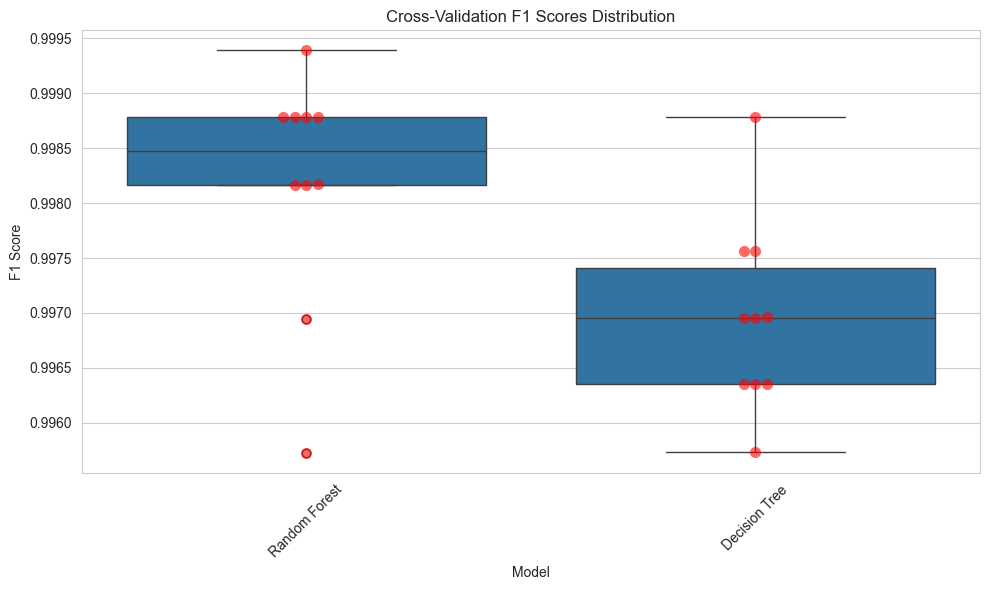

In [76]:
models = {
    'Random Forest': rf_sk,
    'Decision Tree': dt_sk
}

display_cross_validation_results(models, X, y)


In [62]:
cross_val_score(dt_sk, X, y, cv=10, scoring='f1')


array([0.9957291 , 0.9963548 , 0.9963548 , 0.99878197, 0.99756098,
       0.99756098, 0.99695679, 0.99694936, 0.99696049, 0.99635036])

In [63]:
cross_val_score(rf_sk, X, y, cv=10, scoring='f1')


array([0.99572389, 0.99878197, 0.99878197, 0.99939062, 0.99816962,
       0.99816962, 0.99878049, 0.99694563, 0.99878197, 0.99817185])

In [44]:
from sklearn.metrics import classification_report
import pandas as pd
print("Using 34.494 Row Dataset:\n")
print("RandomForest Metric")
print(pd.DataFrame(classification_report(y_test, rf_pred, output_dict=True)).T)

print("\nDecisionTree Metric")
print(pd.DataFrame(classification_report(y_test, dt_pred, output_dict=True)).T)

Using 34.494 Row Dataset:

RandomForest Metric
              precision    recall  f1-score      support
0              0.998809  0.999801  0.999305  5033.000000
1              0.999377  0.996273  0.997823  1610.000000
accuracy       0.998946  0.998946  0.998946     0.998946
macro avg      0.999093  0.998037  0.998564  6643.000000
weighted avg   0.998947  0.998946  0.998946  6643.000000

DecisionTree Metric
              precision    recall  f1-score      support
0              0.999206  0.999603  0.999404  5033.000000
1              0.998756  0.997516  0.998135  1610.000000
accuracy       0.999097  0.999097  0.999097     0.999097
macro avg      0.998981  0.998559  0.998770  6643.000000
weighted avg   0.999097  0.999097  0.999097  6643.000000


In [5]:
def preprocess_single_transaction(
    transaction: Dict[str, Union[str, float, int]]
) -> np.ndarray:
    """
    Preprocess single transaction untuk fraud detection.
    
    Required Input Parameters:
    - type: str - Tipe transaksi (PAYMENT, TRANSFER, CASH_OUT, CASH_IN, DEBIT)
    - amount: float - Jumlah transaksi
    - nameOrig: str - ID akun sumber (format: C... untuk customer)
    - nameDest: str - ID akun tujuan (format: C... untuk customer, M... untuk merchant)
    - hour: int - Jam transaksi (0-23)
    - day_of_week: int - Hari dalam seminggu (0-6)
    
    Optional Parameters (default 0 jika tidak tersedia):
    - oldbalanceOrg: float - Saldo awal akun sumber
    - newbalanceOrig: float - Saldo akhir akun sumber
    - oldbalanceDest: float - Saldo awal akun tujuan
    - newbalanceDest: float - Saldo akhir akun tujuan
    """
    # Convert single transaction to DataFrame
    df = pd.DataFrame([transaction])
    
    # Feature Engineering
    features = {}
    eps = 1e-10  # epsilon untuk menghindari pembagian dengan nol
    
    # 1. Amount-based features
    features['amount'] = transaction['amount']
    features['amount_log'] = np.log1p(transaction['amount'])
    
    # 2. Time-based features
    features['hour'] = transaction['step'] % 24
    features['day_of_week'] = (transaction['step'] // 24) % 7
    features['week'] = (transaction['step'] // 24) // 7
    
    # 3. Account type features
    features['is_customer_orig'] = 1 if transaction['nameOrig'].startswith('C') else 0
    features['is_merchant_dest'] = 1 if transaction['nameDest'].startswith('M') else 0
    
    # 4. Balance-based features (if available)
    oldbalanceOrg = transaction.get('oldbalanceOrg', 0)
    newbalanceOrig = transaction.get('newbalanceOrig', 0)
    oldbalanceDest = transaction.get('oldbalanceDest', 0)
    newbalanceDest = transaction.get('newbalanceDest', 0)
    
    features['balance_diff_orig'] = oldbalanceOrg - newbalanceOrig
    features['balance_diff_dest'] = newbalanceDest - oldbalanceDest
    features['balance_ratio_orig'] = (newbalanceOrig + eps) / (oldbalanceOrg + eps)
    features['balance_ratio_dest'] = (newbalanceDest + eps) / (oldbalanceDest + eps)
    
    # 5. Error checking features
    features['error_balance_orig'] = abs(transaction['amount'] - (oldbalanceOrg - newbalanceOrig))
    features['error_balance_dest'] = abs(transaction['amount'] - (newbalanceDest - oldbalanceDest))
    
    # 6. Derived features
    features['zero_balance_orig'] = int(oldbalanceOrg == 0 or newbalanceOrig == 0)
    features['zero_balance_dest'] = int(oldbalanceDest == 0 or newbalanceDest == 0)
    features['full_transfer'] = int(newbalanceOrig == 0)
    features['balance_mismatch'] = int(abs(oldbalanceOrg - newbalanceOrig) != transaction['amount'])
    
    # 7. Transaction type one-hot encoding
    tx_types = ['PAYMENT', 'TRANSFER', 'CASH_OUT', 'CASH_IN', 'DEBIT']
    for tx_type in tx_types:
        features[f'type_{tx_type}'] = 1 if transaction['type'] == tx_type else 0
    
    # Convert features to DataFrame
    features_df = pd.DataFrame([features])
    
    # Standardize numerical features
    numerical_features = [
        'amount', 'amount_log', 'balance_diff_orig', 'balance_diff_dest',
        'balance_ratio_orig', 'balance_ratio_dest', 'error_balance_orig',
        'error_balance_dest'
    ]
    
    for feature in numerical_features:
        mean_val = features_df[feature].mean()
        std_val = features_df[feature].std()
        if std_val != 0:
            features_df[feature] = (features_df[feature] - mean_val) / std_val
        else:
            features_df[feature] = features_df[feature] - mean_val
    
    # Handle any NaN or infinite values
    features_array = np.nan_to_num(features_df.values, nan=0.0, posinf=0.0, neginf=0.0)
    
    return features_array

def predict_transaction_fraud(model, transaction_data: Dict[str, Union[str, float, int]]) -> Dict:
    """
    Predict fraud untuk single transaction.
    
    Parameters:
    - model: Trained model (DecisionTree atau RandomForest)
    - transaction_data: Dictionary berisi data transaksi
    
    Returns:
    - Dictionary berisi hasil prediksi dan probability
    """
    features = preprocess_single_transaction(transaction_data)
    prediction = model.predict(features)
    
    result = {
        'is_fraud': bool(prediction[0]),
        'transaction_amount': transaction_data['amount'],
        'transaction_type': transaction_data['type'],
        'risk_factors': []
    }
    
    # Analisis faktor risiko
    if transaction_data['amount'] > 200000:
        result['risk_factors'].append('High transaction amount')
    if transaction_data.get('newbalanceOrig', 0) == 0:
        result['risk_factors'].append('Account emptying detected')
    if transaction_data['type'] in ['TRANSFER', 'CASH_OUT']:
        result['risk_factors'].append('High-risk transaction type')
    
    return result

In [46]:
import pandas as pd
df = pd.read_csv(r"C:\Users\user\PycharmProjects\pythonProject\ArtificialIntelegent-Project\FraudDetectionForFinancialTransaction\PS_20174392719_1491204439457_log.csv")
df.head(2)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0


In [78]:
rf_test = df[df["isFraud"] == 1].sample(n=1, random_state=59)
# rf_test = df.head(1)
rf_test

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
1030640,80,CASH_OUT,62134.33,C1079384969,62134.33,0.0,C1087953881,509204.33,571338.66,1,0


In [79]:
transaction_data = {
    "step": rf_test["step"],
    "type": str(rf_test["type"]),        # Tipe transaksi (TRANSFER, CASH_OUT, CASH_IN, DEBIT, PAYMENT)
    "amount": float(rf_test["amount"].iloc[0]),    # Jumlah transaksi
    "nameOrig": rf_test["nameOrig"],
    "nameDest": rf_test["nameDest"],
    "oldbalanceOrg": float(rf_test["oldbalanceOrg"].iloc[0]),  # Saldo awal rekening asal
    "newbalanceOrig": float(rf_test["newbalanceOrig"].iloc[0]), # Saldo akhir rekening asal
    "oldbalanceDest": float(rf_test["oldbalanceDest"].iloc[0]), # Saldo awal rekening tujuan
    "newbalanceDest": float(rf_test["newbalanceDest"].iloc[0])  # Saldo akhir rekening tujuan
}

df_test = pd.DataFrame([transaction_data])

# Preprocess the transaction
features = engineer_features(df_test)

print(features)

# # Make prediction
# prediction = dt.predict(features)

# prediction[0]

TypeError: loop of ufunc does not support argument 0 of type Series which has no callable sin method

In [113]:
rf_test["step"].iloc[0]

449

In [116]:
# Contoh penggunaan untuk testing single transaction
test_transaction = {
    "step": rf_test[rf"step"].values[0],
    "type": str(rf_test["type"].values[0]),        # Tipe transaksi (TRANSFER, CASH_OUT, CASH_IN, DEBIT, PAYMENT)
    "amount": float(rf_test["amount"].iloc[0]),    # Jumlah transaksi
    "nameOrig": rf_test["nameOrig"].values[0],
    "nameDest": rf_test["nameDest"].values[0],
    "oldbalanceOrg": float(rf_test["oldbalanceOrg"].iloc[0]),  # Saldo awal rekening asal
    "newbalanceOrig": float(rf_test["newbalanceOrig"].iloc[0]), # Saldo akhir rekening asal
    "oldbalanceDest": float(rf_test["oldbalanceDest"].iloc[0]), # Saldo awal rekening tujuan
    "newbalanceDest": float(rf_test["newbalanceDest"].iloc[0])    # Saldo akhir tujuan
}

# Prediksi menggunakan model yang sudah ditraining
result = predict_transaction_fraud(dt, test_transaction)
print("\nHasil Prediksi:")
print(f"Fraud Detection: {'YES' if result['is_fraud'] else 'NO'}")
print(f"Transaction Amount: {result['transaction_amount']}")
print(f"Transaction Type: {result['transaction_type']}")
if result['risk_factors']:
    print("\nRisk Factors:")
    for factor in result['risk_factors']:
        print(f"- {factor}")


Hasil Prediksi:
Fraud Detection: NO
Transaction Amount: 0.0
Transaction Type: CASH_OUT

Risk Factors:
- Account emptying detected
- High-risk transaction type
